<a href="https://colab.research.google.com/github/fedhere/DSPS_FBianco/blob/main/HW5/FitLineToGRBAfterGlow_mcmc_instructions_DSOS23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fitting a line to GRB afterglow photometry

In this notebook we will fit a line to data in various ways

Note:
a line is a power law in log-log space. The GRB afterglow is generated by a powerlaw process, and a broken powerlaw is a prefer model for the GRB afterglow.
    

In [79]:
!pip install emcee # install the emcee package that implements the _affine invariant MCMC_ method
!pip install corner
import corner
import pandas as pd
import pylab as pl
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize
import emcee
%pylab inline


Populating the interactive namespace from numpy and matplotlib


Load the data

In [80]:
grbAG = pd.read_csv("https://raw.githubusercontent.com/fedhere/DSPS_FBianco/main/data/grb050525A.csv")

Explore the data

In [81]:
grbAG.head()

,filter,time,mag,magerr,upperlimit
0,V,66,13.21,0.24,0
1,V,67,12.90,0.23,0
2,V,68,12.86,0.23,0
3,V,69,13.01,0.23,0
4,V,70,12.97,0.23,0


In [82]:
grbAG.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119 entries, 0 to 118
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   filter      119 non-null    object 
 1   time        119 non-null    int64  
 2   mag         119 non-null    float64
 3   magerr      108 non-null    float64
 4   upperlimit  119 non-null    int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 4.8+ KB


In [83]:
grbAG.describe()

,time,mag,magerr,upperlimit
count,1.190000e+02,119.000000,108.000000,119.000000
mean,2.767789e+04,16.239282,0.188981,0.092437
std,1.391231e+05,2.506169,0.088676,0.290867
min,6.600000e+01,12.860000,0.060000,0.000000
25%,2.085000e+02,14.340842,0.120000,0.000000
50%,6.240000e+02,15.780000,0.180000,0.000000
75%,6.372500e+03,17.883091,0.230000,0.000000
max,1.171176e+06,22.090000,0.540000,1.000000


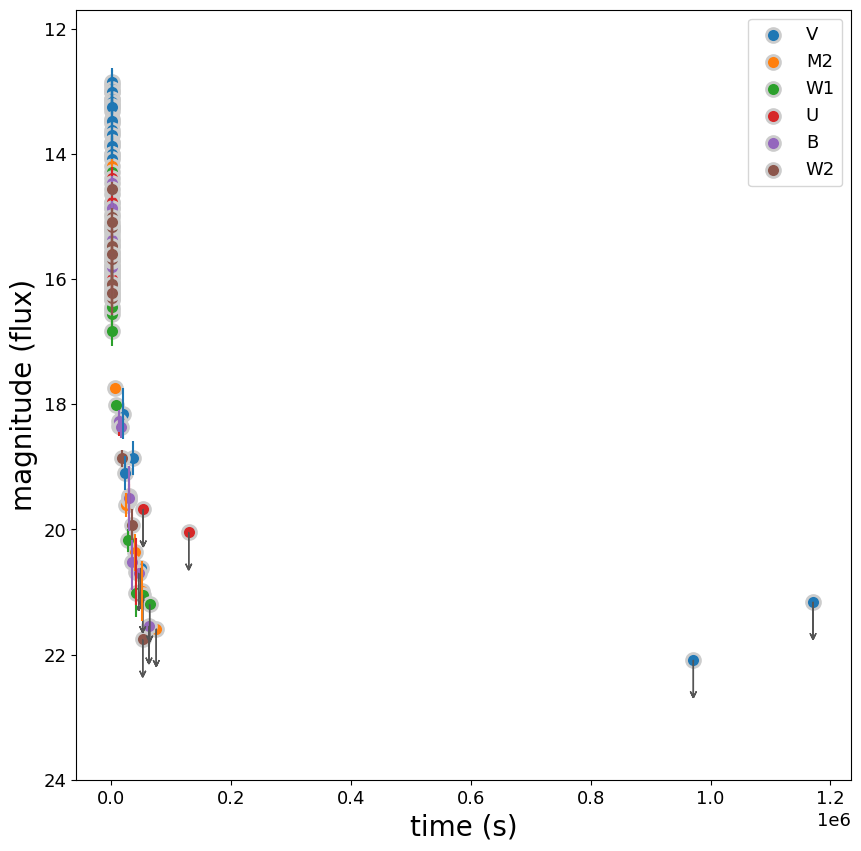

In [84]:
# Plot the data
ax = pl.figure(figsize=(10,10)).add_subplot(111)


for f in grbAG["filter"].unique():
    pl.errorbar(grbAG.loc[grbAG["filter"] == f, "time"],
                grbAG.loc[grbAG["filter"] == f, "mag"],
                yerr=grbAG.loc[grbAG["filter"] == f, "magerr"],
                fmt='.', ms=0,
                fcolor=None, label=None)

for f in grbAG["filter"].unique():
    pl.scatter(grbAG.loc[grbAG["filter"] == f, "time"],
               grbAG.loc[grbAG["filter"] == f, "mag"],
               alpha=1, s=100, linewidth=2,
               label=f,
               edgecolor='#cccccc')


nuplim = grbAG.mag.isna().sum()
for i in grbAG[grbAG.upperlimit == 1].index:
    pl.arrow(grbAG.loc[i].time,
             grbAG.loc[i].mag, 0, 0.5, head_width=1e4,
             overhang=1, shape="full",
             head_length=0.1, ec='#555555', visible=True)

# Invert the y axis because the "magnitude" measurement is an inverse scale: brighter is smaller
pl.ylim(24,11.7)
pl.legend()

pl.ylabel("magnitude (flux)", fontsize=20)
pl.xlabel("time (s)", fontsize=20);

### FIGURE 1: Photometry of the Afterglow of GRB 052505A. All photometry is from the Swift satellite and it is obtained from Table 3 of Blustin et al. 2005 https://arxiv.org/pdf/astro-ph/0507515.pdf. The photometric band for each datapoint is indicated in the legend. Time is relative from the estimated moment of explosion of the stellar progenitor. Upperlimits are indicated by down-pointing arrows. Here we see that the data at this scale is not linear, so lets put it into log space (below) and see that its linear given that we know a GRB afterglow is generated by a powerlaw process.

# Create the log-time variable

We will fit a line in log space. That corresponds to fitting a powerlaw y=x^a in natural space.


In [85]:
grbAG['logtime'] = np.log10(grbAG['time'])
grbAG.head()

,filter,time,mag,magerr,upperlimit,logtime
0,V,66,13.21,0.24,0,1.819544
1,V,67,12.90,0.23,0,1.826075
2,V,68,12.86,0.23,0,1.832509
3,V,69,13.01,0.23,0,1.838849
4,V,70,12.97,0.23,0,1.845098


# Visualize the data
The data are photometric measurements: measurement of flux from an exploding star. The flux is measured in different photometric bands, i.e. within different wavelength range. You can think about this as a filter that would limit the light collected by a camera to a single color, e.g. red, blue, or green. In most all cameras (your phone camera for example) collect data in RGB bands saparately and combine them to create a "color picture". Our eyes also perceive color in 3 bands, R, G, B.

The information about the photometric band is stored in the variable ```grbAG.filter```. Here we plot the data with different colors for different photometric bands.

In [86]:
def plotlogtime(df, models=[]):
  # same plot code as above, could make a single function
  ax = pl.figure(figsize=(10,10)).add_subplot(111)


  for f in grbAG["filter"].unique():
    pl.errorbar(grbAG.loc[grbAG["filter"] == f, "logtime"],
                grbAG.loc[grbAG["filter"] == f, "mag"],
                yerr=grbAG.loc[grbAG["filter"] == f, "magerr"],
                fmt='.', ms=0,
                fcolor=None, label=None)

  for f in grbAG["filter"].unique():
    pl.scatter(grbAG.loc[grbAG["filter"] == f, "logtime"],
               grbAG.loc[grbAG["filter"] == f, "mag"],
               alpha=1, s=100, linewidth=2,
               label=f,
               edgecolor='#cccccc')


  nuplim = grbAG.mag.isna().sum()
  for i in grbAG[grbAG.upperlimit == 1].index:
    pl.arrow(grbAG.loc[i].logtime,
             grbAG.loc[i].mag, 0, 0.5, head_width=0.1,
             overhang=1, shape="full",
             head_length=0.1, ec='#555555', visible=True)

  pl.ylim(24,11.7)
  pl.legend()

  pl.ylabel("magnitude (flux)", fontsize=20)
  pl.xlabel("log time (s)", fontsize=20)
  return ax

<Axes: xlabel='log time (s)', ylabel='magnitude (flux)'>

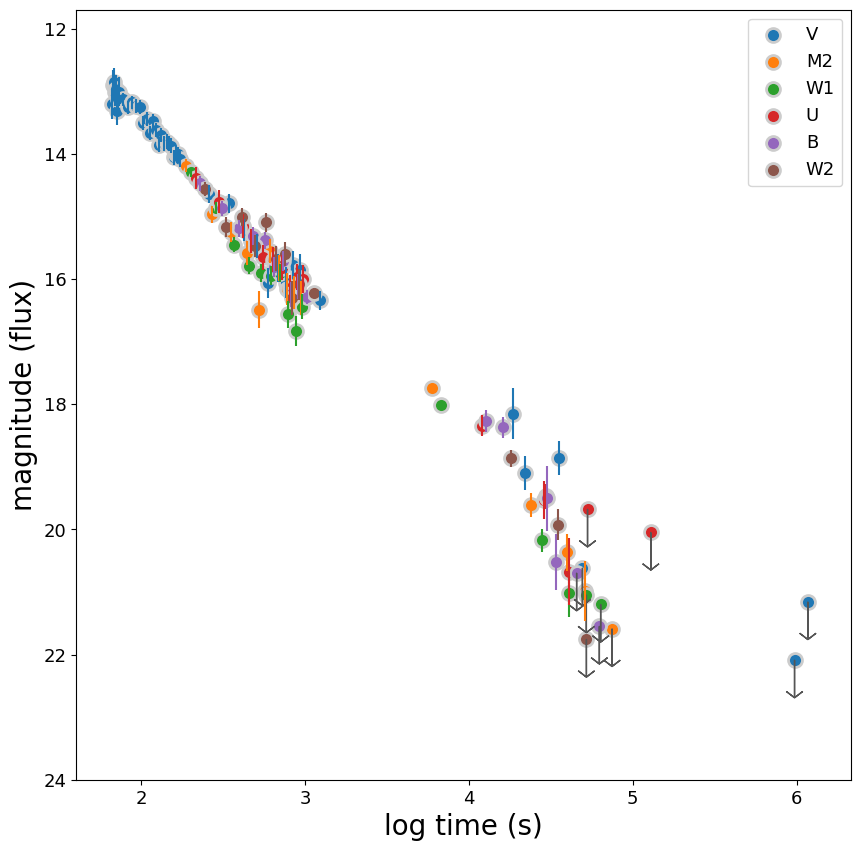

In [87]:
plotlogtime(grbAG)

Figure 2: Photometry of the Afterglow of GRB 052505A in logtime. All photometry is from the Swift satellite and it is obtained from Table 3 of Blustin et al. 2005 https://arxiv.org/pdf/astro-ph/0507515.pdf. The photometric band for each datapoint is indicated in the legend. Time is relative from the estimated moment of explosion of the stellar progenitor. Upperlimits are indicated by down-pointing arrows.

# Solve using the Normal Equation

It can be shown that the best linear fit to data is given by the equation:  

$(X^T \cdot X)^{-1} \cdot X^T \cdot \vec{y}$

The solution is a tuple of 2 parameters: sloper and intercept. Therefore the input has to be Nx2


In [88]:
x = grbAG[grbAG.upperlimit == 0].logtime.values
X = np.c_[np.ones((len(grbAG) - grbAG.upperlimit.sum(), 1)),
          x]


y = grbAG.loc[grbAG.upperlimit == 0].mag.values
print("shape of the input array X", X.shape)
print("shape of the input array y", y.shape)
# note the shape in python is flipped compared to the shape in linear algebra

shape of the input array X (108, 2)
shape of the input array y (108,)


In [89]:
theta_best = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
print ("best fit parameters from the Normal Equation: " +
       "intercept {:.2f}, slope {:.2f}".format(*theta_best))

best fit parameters from the Normal Equation: intercept 8.58, slope 2.51


# Fit a line to the data (excluding the upper limits) with sklearn LinearRegression

The exogenous (independent) variable is ```grbAG.logtime```.

We remove the upper limits by broadcasting



In [90]:
data = grbAG.loc[grbAG.upperlimit == 0]

X = data[['logtime']]
y = data['mag']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # 20% of the data will be used for testing

lr = LinearRegression().fit(X_train, y_train)

intercept = lr.intercept_
slope = lr.coef_[0]

print(f'Intercept: {intercept:.2f}')
print(f'Slope: {slope:.2f}')

train_score = lr.score(X_train, y_train)
test_score = lr.score(X_test, y_test)

print(f'Training R^2 Score: {train_score:.2f}')
print(f'Test R^2 Score: {test_score:.2f}')

Intercept: 8.65
Slope: 2.49
Training R^2 Score: 0.97
Test R^2 Score: 0.97


**HW Part 1: train-test split linear regression. (done above)**

**Q:** what can you say about the model by comparing the two scores?

By comparing the two scores, noting that they are both very high and the same, we can say that the model is correctly extrapolating its learned predictions on the test dataset to the train dataset. If the test score was much lower than the train score, we could say the model is overfitting, because it does not extrapolate well, but this is not the case.

# Fit a line to the data (excluding the upper limits) by minimizing an objective function

First, we choose the L1 and L2 metric (see class notes) as the objective function.

Next, we use ```scipy.optimize.minimize()``` to minimize it.


In [91]:
# model
def line(params, x):
    intercept, slope = params
    return slope * x + intercept

# objective function
def l1(params, x, y):
    model_values = line(params, x)
    return sum(abs(model_values - y))

# guess
initialGuess = [10,2]

# fit
l1Solution = minimize(l1, initialGuess, args=(x, y))
print(l1Solution)
print("")
print("best fit parameters from the minimization of L1: " +
       "slope {:.2f}, intercept {:.2f}".format(*l1Solution.x))

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 26.303331246680866
        x: [ 8.225e+00  2.641e+00]
      nit: 15
      jac: [ 0.000e+00 -7.153e-07]
 hess_inv: [[ 2.678e-05 -5.406e-06]
            [-5.406e-06  5.521e-06]]
     nfev: 156
     njev: 52

best fit parameters from the minimization of L1: slope 8.23, intercept 2.64


In [92]:
def l2(params, x, y):
    '''l2 target function: returns value of l2 for given arguments and data for a line model
    params: (array) model parameters [intercept, slope]
    x: the exogenous variable (array)
    y: the endogenous variable (array)
    returns L2 sum of difference between prediction and data squared
    '''
    model_values = line(params, x)
    return sum((model_values - y) ** 2)


x = data['logtime'].values
y = data['mag'].values

initialGuess = [10, 2]

l2Solution = minimize(l2, initialGuess, args=(x, y))

print(l2Solution)
print("\n")
print("best fit parameters from the minimization of L2: " +
      "intercept {:.2f}, slope {:.2f}".format(*l2Solution.x))

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 12.825987500725411
        x: [ 8.583e+00  2.512e+00]
      nit: 4
      jac: [ 0.000e+00  2.384e-07]
 hess_inv: [[ 6.254e-02 -2.030e-02]
            [-2.030e-02  7.114e-03]]
     nfev: 18
     njev: 6


best fit parameters from the minimization of L2: intercept 8.58, slope 2.51



# Fit a line to the data (excluding the upper limits) by minimizing an objective function that accounts for the measurements uncertainties

Since the data has uncertainty, choose the $\chi^2$ (chi squared) function as your objective function.

In [93]:
def chi2(params, x, y, s):
    '''chi2 target function: returns value of chi2 for given arguments and data for a line model
    params: (array) model parameters [intercept, slope]
    x: the exogenous variable (array)
    y: the endogenous variable (array)
    s: uncertainties associated with y
    returns chi2 sum of squared difference between prediction and data normalized by uncertainties
    '''
    model_values = line(params, x)
    return sum(((y - model_values) / s) ** 2)


x = grbAG[grbAG.upperlimit == 0].logtime.values
y = grbAG.loc[grbAG.upperlimit == 0].mag.values
s = grbAG.loc[grbAG.upperlimit == 0].magerr.values

initialGuess = [8, 2]

chi2Solution = minimize(chi2, initialGuess, args=(x, y, s))
print(chi2Solution)
print("")
print("best fit parameters from the minimization of the chi squared: " +
       "slope {:.2f}, intercept {:.2f}".format(*chi2Solution.x))

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 317.4206698013055
        x: [ 8.599e+00  2.480e+00]
      nit: 5
      jac: [ 7.629e-06  1.030e-04]
 hess_inv: [[ 1.559e-03 -5.429e-04]
            [-5.429e-04  2.017e-04]]
     nfev: 90
     njev: 26

best fit parameters from the minimization of the chi squared: slope 8.60, intercept 2.48


# Plot all the solutions

We create a function that uses the parameters of the model and plots a line. The legend describes which line corresponds to which model.


ValueError: ignored

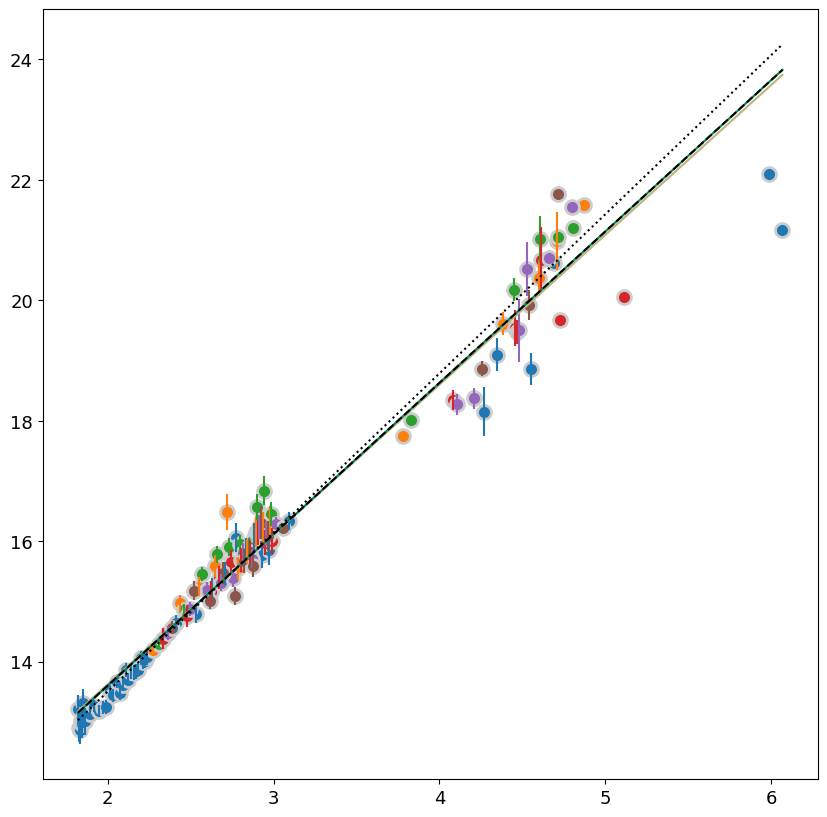

In [130]:
def plotline(pars, x, color='k', symbol='-', label='model',
             alpha=1, ax=ax):
    slope, intercept = pars
    y = line((intercept, slope), x)
    ax.plot(x, y, ls=symbol, c=color, label=label, alpha=alpha)


ax = pl.figure(figsize=(10,10)).add_subplot(111)

for f in grbAG["filter"].unique():
    pl.errorbar(grbAG.loc[grbAG["filter"] == f, "logtime"],
                grbAG.loc[grbAG["filter"] == f, "mag"],
                yerr=grbAG.loc[grbAG["filter"] == f, "magerr"], fmt='.', ms=0,
                fcolor=None, label=None)

for f in grbAG["filter"].unique():
    pl.scatter(grbAG.loc[grbAG["filter"] == f, "logtime"],
               grbAG.loc[grbAG["filter"] == f, "mag"],
               alpha=1, s=100, linewidth=2,
               edgecolor='#cccccc', label=None)


nuplim = grbAG.mag.isna().sum()
for i in grbAG[grbAG.upperlimit == 1].index:
    pl.arrow(grbAG.loc[i].logtime,
             grbAG.loc[i].magerr, 0, 2,
            head_width=0.05, head_length=0.1, ec='k')

colors = ['C2B280', '848482', '008856', 'E68FAC', '0067A5', 'F99379',
          '604E97', 'F6A600', 'B3446C',
          'DCD300', '882D17', '8DB600', '654522', 'E25822', '2B3D26',
          '222222', 'F3C300', '875692', 'F38400', 'A1CAF1', 'BE0032', ]

plotline((lr.coef_[0], lr.intercept_), grbAG.logtime.values,
         color='#'+colors[0],
         label="Normal Equation", ax=ax)

plotline((theta_best[::-1]), grbAG.logtime,
         color='#'+colors[2], symbol='-',
         label="sklearn LinearRegression", ax=ax)

plotline((l1Solution.x[::-1]), grbAG.logtime,
         symbol=':',
         label="L1 minimization", ax=ax)

plotline((l2Solution.x[::-1]), grbAG.logtime,
         symbol='--',
         label="L2 minimization", ax=ax)

plotline((chi2Solution.x[::-1]), grbAG.logtime,
         color='#'+colors[3], symbol='-.',
         label=r"$\chi^2$ minimization", ax=ax)

pl.legend()

#with the LinearRegression object I can also do
#pl.plot(grbAG.logtime, lr.predict(np.c_[np.ones((len(grbAG), 1)), grbAG.logtime]), 'k-')

pl.ylim(24.5,11.7)
pl.xlim(1.5, 6.5)
pl.ylabel("magnitude (flux)", fontsize=20)
pl.xlabel("log time (s)", fontsize=20);

Figure 3: Same as Figure 1 and 2, but with models plotted. The models correspond to the best fit line to the data (excluding upper limits) calculated analytically by solving the normal equation, by solving the fit analysitcally with sklearn.LinearRegression(), and by minimizing the objective functions L1, L2, and chi^2. The models are indicated in the legend.

# Now we fit a line to the data with MCMC

documentation: https://emcee.readthedocs.io/en/stable/

We are implementing Bayes theorem to find the best model parameters: $P(\theta | D) ~ P(D | \theta) * P(\theta)$ or _Posterior ~ Likelihood * Prior_

Since we are maximizing the likelihood, we work in log space because:
- the logarithm is a monotonic function of its argument (meaning where the argument gets bigger its log gets bigger, where it gets smaller its log gets smaller)
- the log is not defined for negative values (log(something < 0) is undefined) but this does not matter because the likelihood is a probability and probabilities are positive defined.



In [95]:
# LINE MODEL
def log_prior(theta):
  slope, intercept = theta
  if slope > 0 and intercept > 0:
    return 0

  #semi informative prior: i know light has to get fainter (mag get bigger)
  #i know i dont use negative mags
  return -np.inf


In [96]:
#log likelihood
def log_likelihood(theta, x, y, yerr):
  slope, intercept = theta
  #chi2 likelihood : (data-model)**2 / uncertainty **2
  return -np.sum(((y - line((intercept, slope), x))**2) / yerr**2)

In [97]:
#log posterior
def log_posterior(theta, x, y, yerr):
  lp = log_prior(theta)
  if not np.isfinite(lp):
    return -np.inf
  # posterior ~ likelihood * prior => log_posterior ~ log_likelihood + log_prior
  return lp + log_likelihood(theta, x, y, yerr)

In [98]:
#initial guess
ig = [1,10]

In [99]:
#initialize N walkers
nwalkers = 32
ndim = len(ig)

In [100]:
pos = np.array(ig) + 1e-4 * np.random.randn(nwalkers, ndim) #the starting point for each walker is a small perturbation of the initial guess

In [101]:
pos.shape

(32, 2)

In [102]:
# this sets up the model and assignes the hyperparameters
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(x, y, s))

In [103]:
# this runs the MCMC for 5,000 steps
sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [00:18<00:00, 273.18it/s]


In [104]:
# this extracts the ergodic markovian chains of positions in the feature space
samples = sampler.get_chain()

In [105]:
samples.shape

(5000, 32, 2)

In [106]:
# to get statistical properties of the chains I will concatenate the 32 chains. This works _iff_ the chains are independent
# note: the chains are _assumed_ to be independent
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)

In [107]:
#the result of the mcmc (the best parameters and their uncertainties) are statistical properties of the chains
# I recommand the median and percentiles over the mean and standard deviation, since the chains need not be gaussian
mcmc = np.zeros((ndim, 3))
for i in range(ndim):
  mcmc[i] = np.percentile( flat_samples[:,i], [16, 50, 84])
mcmc

array([[2.46659278, 2.48062019, 2.49436224],
       [8.55944736, 8.59876656, 8.63750173]])

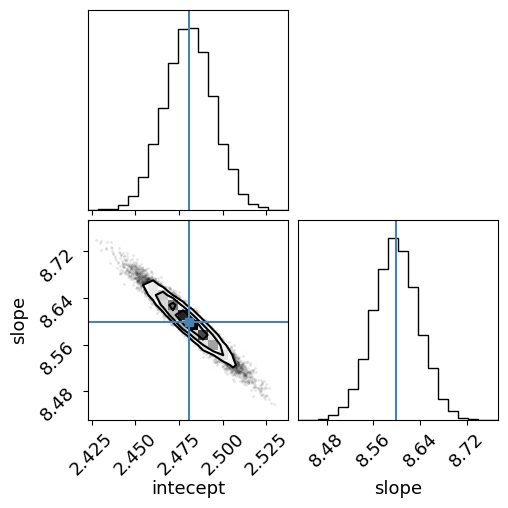

In [108]:
#plotting the likelihood space: the panels are 2D projections of the feature space and 1D marginalized probabilities for each parameters
pl.rcParams["font.size"]= 13
fig = corner.corner(
    flat_samples, labels=["intecept", "slope"], truths=mcmc[:,1]);


Figure 3. Histograms of intercept and slope Markov chain values (top left and bottom right, respectively). Both parameters follow a Gaussian distribution. The bottom left panel shows that there is a correlation between the these parameters.

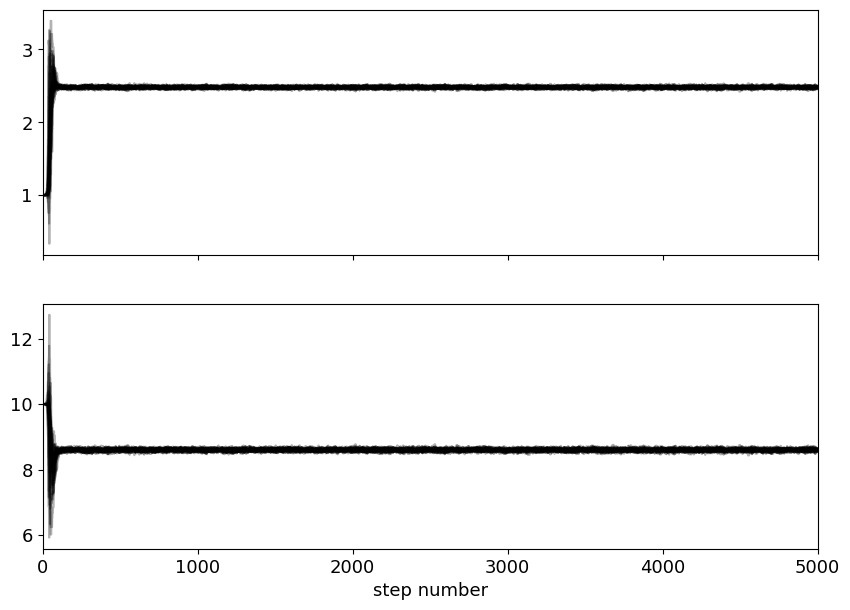

In [109]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

Figure 4. Markov chains as a function of step number for the a linear fit of the data. Very quickly the both the values for the intercept and the slope converge close to the "true" value.

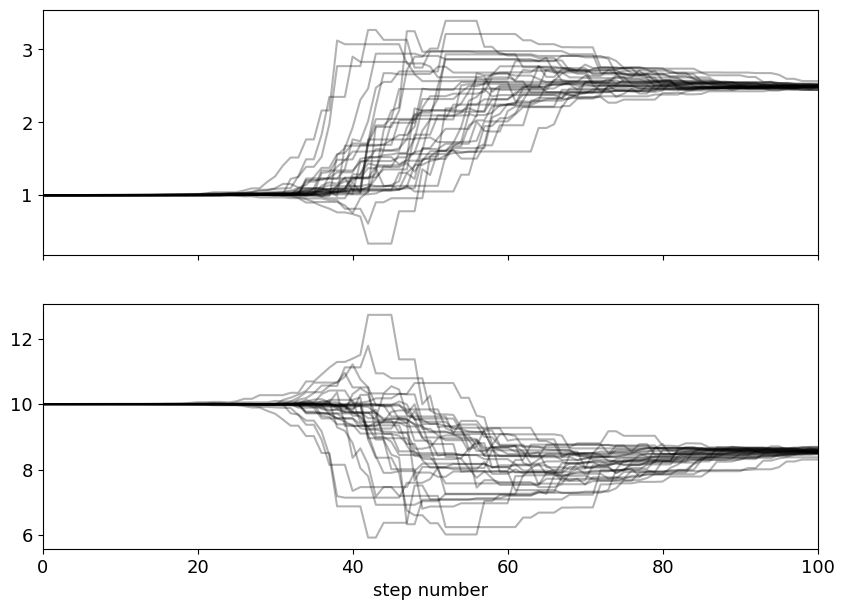

In [110]:
# zoom in: the beginning of the chain should be cut - this is the burn-in part of the chain
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, 100) #len(samples))
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

Figure 5. Zoomed in section of Figure 4. Here we see how Markov chain initially diverge, but after ~100 steps converge to the "true" value.

In [111]:
# save the mcmc results for later
mcmc_line = mcmc

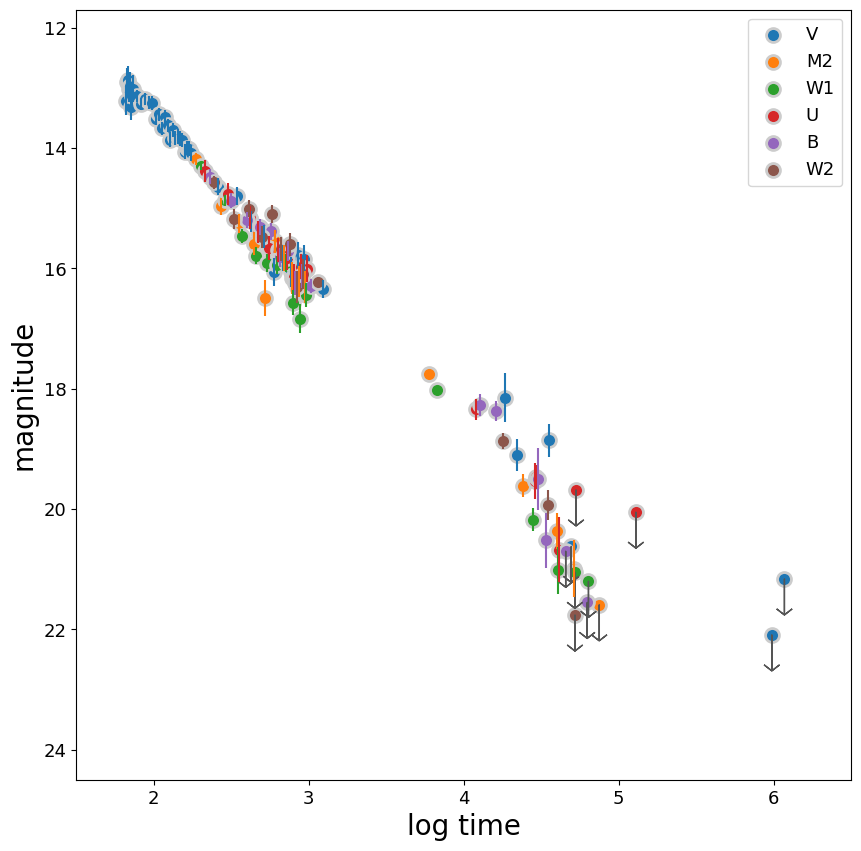

In [112]:
labels = ["intercept","slope"]
ax = plotlogtime(grbAG)
#plotting models
#use Kelley colors for maximum readability
#https://gist.github.com/ollieglass/f6ddd781eeae1d24e391265432297538
colors = ['C2B280', '848482', '008856', 'E68FAC', '0067A5', 'F99379',
          '604E97', 'F6A600', 'B3446C',
          'DCD300', '882D17', '8DB600', '654522', 'E25822', '2B3D26',
          '222222', 'F3C300', '875692', 'F38400', 'A1CAF1', 'BE0032', ]

# ax.plot(np.arange(1.5,6,0.01),
#         bpl(ig, 10**np.arange(1.5,6,0.01)), ls="--", c="k",
#         label="MCMC") NOTE TODO What is this

pl.legend()

#with the LinearRegression object I can also do
# pl.plot(grbAG.logtime, lr.predict(np.c_[np.ones((len(grbAG), 1)), grbAG.logtime]), 'k-')

pl.ylim(24.5,11.7)
pl.xlim(1.5, 6.5)
pl.ylabel("magnitude", fontsize=20)
pl.xlabel("log time", fontsize=20);

# Now we try a broken power law (BPL) model

A power law is not a good model for GRB afterglows. A broken power law has been known to be a better model and has several physical motivations. In this part we will fit a _broke power law_ to the data, which is a more complex and higher dimensional model than the simple line fit we did so far, with MCMC getting best values for the posterior, a complete characterization of the likelihood, and allowing model selection between the line and the power law.

>A broken power law is a power law ($y ~ x^a$) where the power a changes at some point. This can be caused by the presence of two power law processes with different, for example, where one dominates at early time and the other at late times.


>>Gamma-ray bursts (GRBs) are produced by the collapse of massive stars or the merger of compact objects like neutron stars. The energy of the collapse is highly energetic (Gamma rays) but the emission gets reprocessed as it leaves the system and looses energy becoming detectable in the optical wavelengths. This is called the "optical afterglow of the GRB".
>>The explosion resulting from the collapse generates a highly relativistic outflow of material that moves at a significant fraction of the speed of light.
>> The afterglow emission is primarily produced through synchrotron radiation, where charged particles spiral around magnetic field lines. The radiation produced by synchrotrone follows a power law with an index that depends on the density of the surrounding medium, the Lorentz factor of the outflow, and the magnetic field strength. As the radiation crosses different regions of the system that collapsed these factors change and the powerlaw index changes with them.

>>If the relativistic outflow is highly collimated (a jet) as the jet expands, its emission can be modeled as a power-law light curve, but  where the jet begins to decelerate and spread out the slope of the power law changes. This transition is known as the "jet break" and results in a broken power-law behavior.

>> Some GRBs exhibit late-time flares or additional energy injection from the central engine but we are not modeling this in this exercise.




_BPL model variables:_

$F = \mathrm{flux}$ - note: not magnitude this time! $mag ~ -2.5log10(Flux)$

$t =  \mathrm{time}$ - note: not log time

_BPL model parameters:_


$T_b =  \mathrm{Time~of~break}$

$a_1:  \mathrm{Early~slope}$

$a_2: \mathrm{Late~slope}$

$b:  \mathrm{nuisance~parameters}$

_BPL model_:

$F=\frac{F_0}{ \frac{t}{T_b}^{-a1} + \frac{t}{T_b}^{-a2}}$


$b - log_{10}((\frac{t}{T_b})^{-a1} + (\frac{t}{T_b})^{-a2}) $



In [113]:
t = grbAG[grbAG.upperlimit == 0].time.values

In [114]:
t.min(), t.max()

(66, 51257)

create the model `bpl()`, the `log_likelihood()`, `log_prior()` (here we choose what we want to set our prior to), and `log_posterior()`

In [115]:
def bpl(theta, t):
    """broken power law model
    Input:
      theta: (array like) 4 parameters vector, see equation
      x: (array like) independent variable
    Return:
      model predictions for each x (array like)
    """
    Tb, a1, a2, b = theta
    tmp = (t / Tb)
    F = ((tmp ** -a1) + (tmp ** -a2))
    return b - np.log10(F)


In [116]:
def log_likelihood_bpl(theta, x, y_obs, y_err):
    y_model = bpl(theta, x)

    chi2 = np.sum(((y_obs - y_model) / y_err)**2)
    return -0.5 * chi2  # Return negative half chi-squared as the log-likelihood

def log_prior_bpl(theta):
    Tb, a1, a2, b = theta
    if 0 < Tb < 100000 and -10 < a1 < 10 and -10 < a2 < 10 and -10000 < b < 10000:
        return 0  # Log of 1 for uniform prior
    return -np.inf  # Log of 0 outside the reasonable range

def log_posterior_bpl(theta, x, y_obs, y_err):
    log_pri = log_prior_bpl(theta)
    if not np.isfinite(log_pri):
        return -np.inf
    return log_pri + log_likelihood_bpl(theta, x, y_obs, y_err)


Find the initial starting point as a stochastic gradient descent minimization of the log likelihood

In [117]:
def neg_log_likelihood_bpl(theta, x, y_obs, y_err):
    return -log_likelihood_bpl(theta, x, y_obs, y_err)

ig = [0.2, 5, 1000, 20]
bounds = [(66, 51257), (-10, 10), (-10, 10), (-1000, 1000)]
soln = minimize(neg_log_likelihood_bpl, ig, args=(t, y, s), bounds=bounds)
# soln = minimize(neg_log_likelihood_bpl, ig, args=(t, y, s))

soln

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 108.73265732293527
        x: [ 2.736e+02  2.146e+00  3.548e+00  1.505e+01]
      nit: 51
      jac: [ 4.405e-05  7.923e-03  3.682e-03 -5.672e-03]
     nfev: 335
     njev: 67
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>

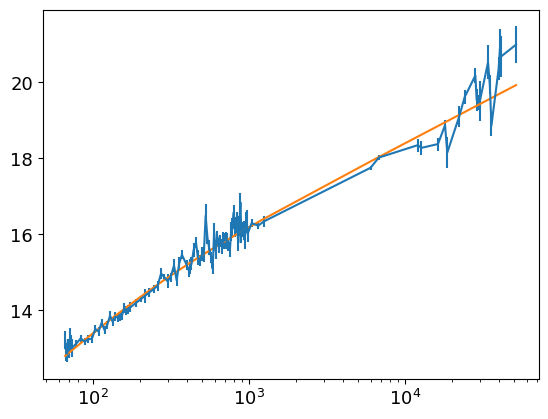

In [118]:
ig = soln.x # the initial guess for the MCMC

# plot the model as it looks with the initial guess values
pl.errorbar(t, y, yerr=s)
pl.plot(t, bpl(ig, t))
pl.xscale("log")

Figure 6. Stochastic gradient descent minimization of log likelihood to obtain parameters of BPL model fit to the data. We will use these values as our initial guess in the MCMC optimization.

- set the emcee hyperparameters
- run the chains
- extract the statistical properties of the chain as the best fit values
- plot the model
- plot the marginalized posteriors of the model parameters

In [119]:
ndim = len(ig)

nwalkers = 32

# initialize the walkers in a tiny Gaussian ball around the maximum likelihood result.
pos = ig + 1e-2 * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior_bpl, args=(t, y, s))

In [120]:
# run the model for 5000 steps|
sampler.run_mcmc(pos, 1000, progress=True)

100%|██████████| 1000/1000 [00:05<00:00, 170.21it/s]


State([[234.66036563   2.21643044   3.61994373  14.84274569]
 [257.59002826   2.17306502   3.62250847  14.96385294]
 [334.86989826   2.08492298   3.52935123  15.3160088 ]
 [277.98997986   2.1275534    3.62947791  15.08428153]
 [350.09745164   2.08572585   3.51378041  15.33897916]
 [374.6288734    2.12238714   3.26373779  15.39447599]
 [444.6164295    2.14440298   3.25161442  15.61024662]
 [302.61602625   2.09656874   3.50708612  15.17414592]
 [412.33756516   2.0811008    3.25316564  15.50775385]
 [229.33732828   2.19774348   3.67915356  14.83095851]
 [187.93392852   2.20157477   3.75645108  14.58592448]
 [451.70828428   2.07359129   3.37414317  15.64559157]
 [279.85230885   2.13739057   3.54876492  15.06323751]
 [268.99133464   2.17203304   3.48816956  15.02046459]
 [334.41735725   2.11631757   3.38754659  15.27111808]
 [359.17524382   2.09268006   3.37500048  15.35287702]
 [375.32133176   2.01526101   3.39827262  15.44564181]
 [419.02183403   2.06445301   3.26007803  15.53317935]
 [26

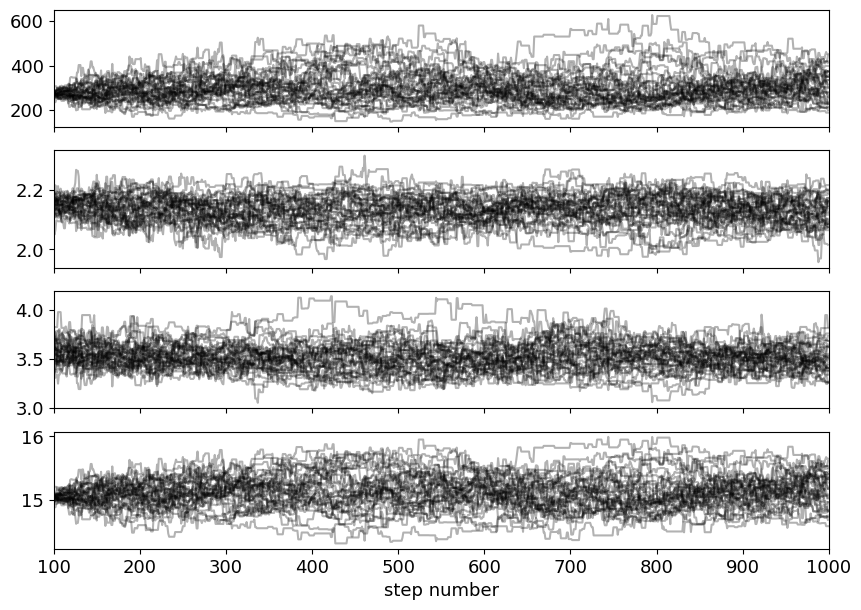

In [121]:
#plot the chains
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(100, len(samples))
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")
plt.show()

Figure 7. Monte Carlo Markov Chains for the optimization of parameters in the broken power law. From top to bottom: time of break, early slope, late slope, and nuisance parameter. We see that we start at a good point, so the chains remain around the same values. This plot shows the algorithms exploring the parameter space in order to find the optimal parameters.

In [122]:
# get the 16th, 50, and 84th percentiles of the model parameters
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
mcmc = np.zeros((ndim, 3))
for i in range(ndim):
    mcmc[i] = np.percentile(flat_samples[:, i], [16, 50, 84])

# mcmc[:,1]
mcmc

array([[232.26728833, 286.60376929, 365.46011377],
       [  2.08559238,   2.13581173,   2.18297041],
       [  3.37044084,   3.51334019,   3.65477786],
       [ 14.85245021,  15.10511396,  15.39347404]])

[[232.26728833 286.60376929 365.46011377]
 [  2.08559238   2.13581173   2.18297041]
 [  3.37044084   3.51334019   3.65477786]
 [ 14.85245021  15.10511396  15.39347404]]


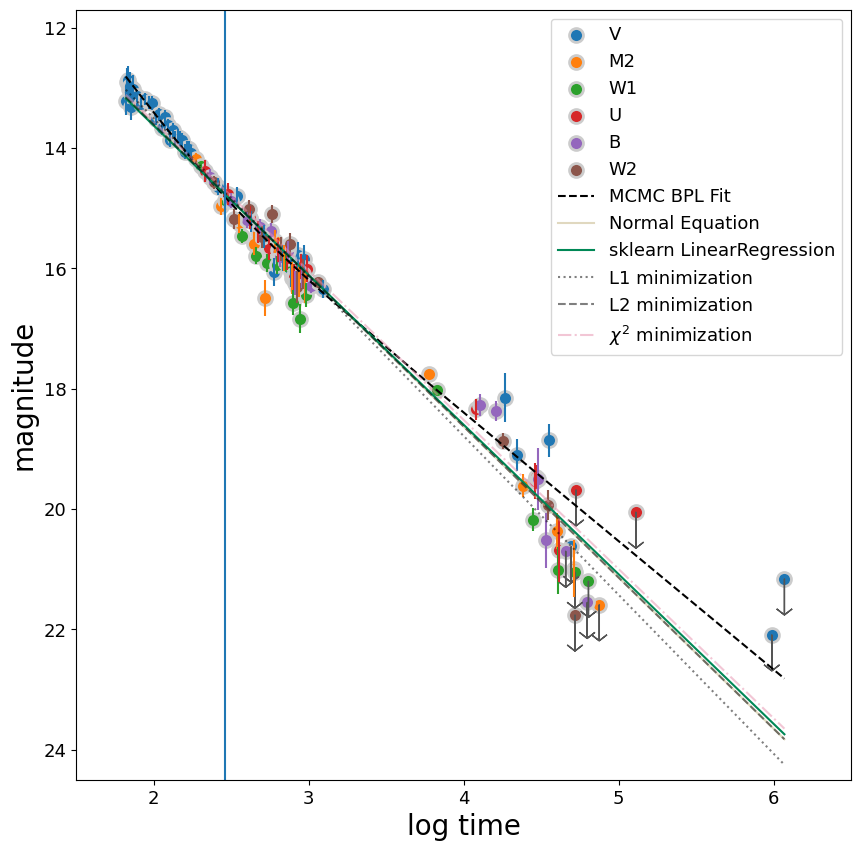

In [123]:
#plot the model
ax = plotlogtime(grbAG)

#plotting models
#use Kelley colors for maximum readability
#https://gist.github.com/ollieglass/f6ddd781eeae1d24e391265432297538
colors = ['C2B280', '848482', '008856', 'E68FAC', '0067A5', 'F99379',
          '604E97', 'F6A600', 'B3446C',
          'DCD300', '882D17', '8DB600', '654522', 'E25822', '2B3D26',
          '222222', 'F3C300', '875692', 'F38400', 'A1CAF1', 'BE0032', ]

# ax.plot(grbAG.logtime.values, line((mcmc[:,1][0], mcmc[:,1][1]),
#                             grbAG.logtime.values), ls="--", c="k", label="MCMC")
best_params = mcmc[:, 1]

bpl_predictions = bpl(best_params, grbAG.time.values)
ax.plot(grbAG.logtime.values, bpl_predictions, ls="--", c="k", label="MCMC BPL Fit")

#normal equation
plotline((theta_best[::-1]), grbAG.logtime.values,
         color='#'+colors[0],  alpha=0.5,
         label="Normal Equation", ax=ax)
#sklearn
plotline((lr.coef_[0], lr.intercept_), grbAG.logtime,
         color='#'+colors[2], symbol='-',
         label="sklearn LinearRegression", ax=ax)
#minimize L1
plotline((l1Solution.x[::-1]), grbAG.logtime,
         symbol=':', alpha=0.5,
         label="L1 minimization", ax=ax)
#minimize L2
plotline((l2Solution.x[::-1]), grbAG.logtime,
         symbol='--', alpha=0.5,
         label="L2 minimization", ax=ax)
#minimize chi2
plotline((chi2Solution.x[::-1]), grbAG.logtime,
         color='#'+colors[3], symbol='-.', alpha=0.5,
         label=r"$\chi^2$ minimization", ax=ax)

pl.legend()

#with the LinearRegression object I can also do
#pl.plot(grbAG.logtime, lr.predict(np.c_[np.ones((len(grbAG), 1)), grbAG.logtime]), 'k-')
print(mcmc)
pl.axvline(np.log10(mcmc[0,1]))
pl.ylim(24.5,11.7)
pl.xlim(1.5, 6.5)
pl.ylabel("magnitude", fontsize=20)
pl.xlabel("log time", fontsize=20);

Figure 8. Comparison of all fittings (like Figure 2), including the broken power law fitting. The vertical line shows the time at which the broken power law switches from one slope to another. This plot shows the comparison of different fits, and is interesting because it shows how the different approaches can give different results.

## plot the marginalized posterior distributions of the parameters

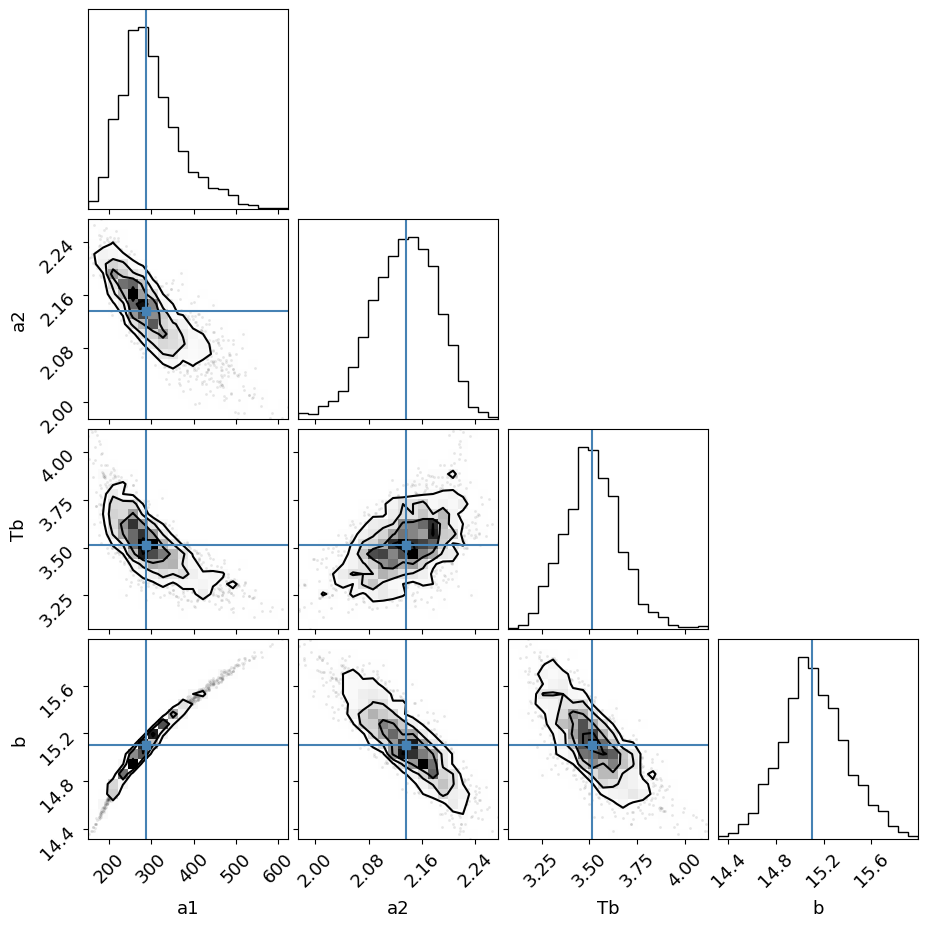

In [124]:

pl.rcParams["font.size"]= 13
fig = corner.corner(
    flat_samples, labels=["a1", "a2", "Tb", "b"], truths=mcmc[:,1]);



Figure 9. Marginalized Posterior Distributions for Broken Power Law (BPL) Model Parameters.This figure presents the marginalized posterior distributions of the parameters from the Broken Power Law (BPL) model, optimized using Markov Chain Monte Carlo (MCMC) methods. The analysis involved setting appropriate hyperparameters for the emcee sampler, running the MCMC chains to convergence, and subsequently extracting the statistical properties of the chain to determine the best-fit values of the model parameters. The diagonal plots show the marginalized distributions of individual parameters, while the off-diagonal plots showcase the pair-wise correlations between parameters. The blue lines represent the best-fit values as determined from the MCMC analysis. By observing the shapes and orientations of the distributions and correlations, we can infer the degrees of uncertainty and degeneracy in our model parameters, guiding us in interpreting the robustness and reliability of the BPL model fit.






# Compare the line (as obtained by the MCMC) and broken power law models.
-  loglikelihood of each model 


-  AIC and BIC



In [125]:
log_likelihood_line_val = log_likelihood(mcmc_line[:,1], x, y, s)
log_likelihood_bpl_val = log_likelihood_bpl(mcmc[:,1], t, y, s)

print("Log-Likelihood (Line Model): {:.4f}".format(log_likelihood_line_val))
print("Log-Likelihood (BPL Model): {:.4f}".format(log_likelihood_bpl_val))

Log-Likelihood (Line Model): -317.4221
Log-Likelihood (BPL Model): -108.7744


## Implement the likelihood ratio test printing out the likelihood ratio statistics

The likelihood-ratio test assesses the goodness of fit of two competing _nested_ statistical models based on the values of the likelihood $L$ where $M1$ is the restricted model (the parameter space is smaller, hence restricted), nested inside $M2$, the full model (the more complex one).

$ \lambda_\mathrm{LR}=-2\ln {\frac {L(M1(\theta_\mathrm{restricted}))}{L(M2(\theta_\mathrm{full}))}}$

This statistics is expexted to be $\chi2$ distributed following a $ch2$ distribution with d.o.f=difference in size of the parameter space in the two models (number of parameters in bpl model - number of parameters in line model).


In [126]:
def like_ratio_statistics(log_likelihood_restricted, log_likelihood_full, df):
    return -2 * (np.log(log_likelihood_restricted / log_likelihood_full))

# Calculate the likelihood ratio statistic
chi2_degrees_of_freedom = len(mcmc[:,1]) - len(mcmc_line[:,1])  # Difference in the number of parameters
lr_statistic = like_ratio_statistics(log_likelihood_line_val, log_likelihood_bpl_val, chi2_degrees_of_freedom)

print("Likelihood Ratio Statistic: {:.4f}".format(lr_statistic))

# Calculate the likelihood ratio statistic
chi2_degrees_of_freedom = len(mcmc[:,1]) - len(mcmc_line[:,1])  # Difference in the number of parameters
lr_statistic = like_ratio_statistics(np.exp(log_likelihood_line_val), np.exp(log_likelihood_bpl_val), chi2_degrees_of_freedom)

print("Likelihood Ratio Statistic: {:.4f}".format(lr_statistic))



Likelihood Ratio Statistic: -2.1419
Likelihood Ratio Statistic: 417.2954


## AIC and BIC: Aikiki Information Criterion and Bayesian Information Criterion for the comparison of the same two models.


In [127]:
def aic(x, l, k):

  return (2 / len(x)) * (k - l)


def bic(x, l, k):
  return np.log(len(x)) * k - 2 * l


In [128]:
print("AIC line {0:.2f} , AIC bpl {1:.2f}".format(aic(x, log_likelihood(mcmc_line[:,1], x, y, s), 2),
                                      aic(x, log_likelihood_bpl(mcmc[:,1], t, y, s), 4)))

print("BIC line {0:.2f} , BIC bpl {0:.2f}".format(bic(x, log_likelihood(mcmc_line[:,1], x, y, s), 2),
                                      bic(x, log_likelihood_bpl(mcmc[:,1], t, y, s), 4)))

AIC line 5.92 , AIC bpl 2.09
BIC line 644.21 , BIC bpl 644.21


 redefine the chi2 written above to take a n deg polynomial, fit it to the data, compare it to the BPL model

Based on chi2 value, Polynomial model provides a better fit.
AIC Values: [455.48076496793914, 1.7866282243182732, 1.7588898041563326, 1.6963338264635994, 1.6893155781049618, 15.688443170022591]
BIC Values: [104883.53229644209, 419.2018621617321, 415.4200250709112, 403.62114908560375, 404.61030786663895, 3630.6337288597438]


<ipython-input-115-68cf1ce75784>:11: RuntimeWarning: divide by zero encountered in reciprocal
  F = ((tmp ** -a1) + (tmp ** -a2))


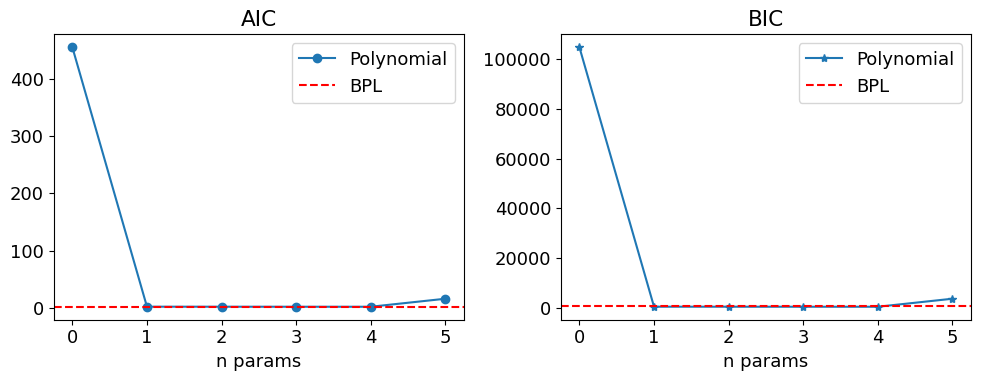

In [129]:
def chi2(pars, x, y, s):
    """
    Calculate the chi-squared values for both a polynomial model and the BPL model.

    Parameters:
    - pars (list): Coefficients of the polynomial model followed by the BPL parameters (Tb, a1, a2, b).
    - x (array-like): Independent variable (time) values.
    - y (array-like): Observed dependent variable (magnitude) values.
    - s (array-like): Uncertainties in the observed values.

    Returns:
    - chi2_poly (float): Chi-squared value for the polynomial model.
    - chi2_bpl (float): Chi-squared value for the BPL model.
    """
    polynomial_coeffs = pars[:-4]
    bpl_params = pars[-4:]

    poly_model = np.polyval(polynomial_coeffs, x)
    chi2_poly = np.sum(((y - poly_model) / s) ** 2)

    bpl_model = bpl(bpl_params, x)
    chi2_bpl = np.sum(((y - bpl_model) / s) ** 2)

    return chi2_poly, chi2_bpl

def chi2_poly(params, x, y, s):
    return np.sum((y - np.polyval(params[::-1], x))**2 / s**2)

# Fake data for illustration (Replace with actual data)
x = np.linspace(0, 10, 100)
y = np.polyval([1, -2, 3], x) + np.random.normal(0, 0.5, x.shape)
s = np.ones_like(x) * 0.5

# Initial guess and model comparison
initialGuess = [1, 1, 1, 1, 1, 1, 1, 1]
chi2_poly_val, chi2_bpl_val = chi2(initialGuess, x, y, s)

if chi2_poly_val < chi2_bpl_val:
    print("Based on chi2 value, Polynomial model provides a better fit.")
else:
    print("Based on chi2 value, BPL model provides a better fit.")

# Fit n-degree polynomials and get AIC/BIC
initialGuess = [10]
aics, bics = [], []

# Assuming you have the AIC and BIC values for the BPL model
aic_bpl = 2.09
bic_bpl = 644.21

# Fit n-degree polynomials and get AIC/BIC
initialGuess = [10]
aics, bics = [], []

for _ in range(6):
    initialGuess.append(1)

    chi2Solution = minimize(chi2_poly, initialGuess, args=(x, y, s))
    aic_value = aic(x, len(initialGuess), chi2Solution.fun)
    bic_value = bic(x, len(initialGuess), chi2Solution.fun)

    aics.append(aic_value)
    bics.append(bic_value)

print("AIC Values:", aics)
print("BIC Values:", bics)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.set_title("AIC")
ax1.plot(aics, 'o-', label='Polynomial')
ax1.axhline(y=aic_bpl, color='r', linestyle='--', label='BPL')
ax1.set_xlabel("n params")
ax1.legend()

ax2.set_title("BIC")
ax2.plot(bics, '*-', label='Polynomial')
ax2.axhline(y=bic_bpl, color='r', linestyle='--', label='BPL')
ax2.set_xlabel("n params")
ax2.legend()

plt.tight_layout()
plt.show()

Figure 10: Comparison of Model Selection Criteria for Various Polynomial Degrees. This figure showcases the Akaike Information Criterion (AIC) and Bayesian Information Criterion (BIC) values for polynomial models of different degrees, ranging from 1 to 6, fitted to the observational data. The models are compared against a Broken Power Law (BPL) model to ascertain the best fit. The left panel displays the AIC values for each polynomial degree, with a lower AIC indicating a preferable model when balancing goodness of fit and model complexity. The right panel exhibits the BIC values, which similarly guide model selection but impose a stronger penalty for additional parameters, favoring simpler models. The polynomial model of degree 2 exhibits the lowest AIC and BIC among the polynomial fits, suggesting it as the preferred model under these criteria.

